In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import LocalOutlierFactor
from kneed.knee_locator import KneeLocator

In [2]:
df = pd.read_csv('../Data/df_cleaned.csv')

In [3]:
df.columns

Index(['Unnamed: 0', 'LBXTC', 'RIAGENDR', 'RIDRETH3', 'RIDAGEYR', 'BMXWT',
       'BMXHT', 'BMXBMI', 'BPXPLS', 'BPXPULS', 'DR1TKCAL', 'DR1TPROT',
       'DR1TCARB', 'DR1TSUGR', 'DR1TFIBE', 'DR1TTFAT', 'DR1TSFAT', 'DR1TMFAT',
       'DR1TPFAT', 'DR1TCHOL', 'DR1TSODI', 'DR1TVD', 'DR1TCALC', 'DR1TIRON',
       'DR1TPOTA', 'DR1_300', 'ALQ120Q', 'ALQ120U', 'ALQ130', 'BPQ020',
       'BPQ050A', 'BPQ080', 'BPQ100D', 'DIQ010', 'MCQ170M', 'SMQ681', 'PAQ610',
       'PAD615', 'PAQ625', 'PAD630', 'PAQ655', 'PAD660', 'PAQ670', 'PAD675',
       'Systolic', 'Diastolic'],
      dtype='object')

In [4]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
df.dropna(inplace=True)
df.shape

(3538, 45)

# Using DBSCAN to look for outliers

Using the elbow method and a k_neighbors graph to find an epsilon. 

The elbow occurs at 2705.126602700509


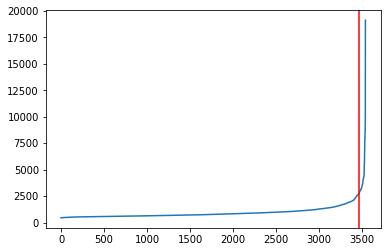

In [6]:
neighbors = NearestNeighbors(n_neighbors=90)
neighbors_fit = neighbors.fit(df)
distances, _ = neighbors_fit.kneighbors(df)
distances = np.sort(distances, axis=0)
distances = distances[:,89]
plt.plot(distances)
kl = KneeLocator(x=range(df.shape[0]),y=distances,direction='increasing',curve='convex')
elbow = kl.elbow
plt.axvline(x=elbow, ymin=0, ymax = max(distances), color='red')
print('The elbow occurs at',distances[elbow])


The epsilon suggested by the curve is 2705

In [7]:
db = DBSCAN(eps=2705, min_samples=46)

In [8]:
preds = db.fit_predict(df)

In [9]:
sum(preds==-1)

16

According to DBSCAN there are 16 outliers.  Note to self, I could add this to the dataframe as 1*(preds==-1) as outlier

In [10]:
outliers1 = df[preds==-1].index
outliers1

Int64Index([ 152,  986, 1516, 1689, 2004, 2191, 2778, 2779, 2984, 3478, 3685,
            4027, 4064, 4076, 4078, 4092],
           dtype='int64')

# Using Local Outling Factor to find outliers

In [11]:
lof = LocalOutlierFactor()

In [12]:
preds2 = lof.fit_predict(df)

In [13]:
outliers2 = df[preds2==-1].index
outliers2

Int64Index([ 102,  145,  147,  152,  174,  362,  374,  380,  418,  510,  558,
             644,  745,  828,  854,  861,  930,  986, 1002, 1012, 1045, 1054,
            1107, 1185, 1242, 1260, 1288, 1314, 1392, 1484, 1516, 1554, 1676,
            1689, 1738, 1761, 2004, 2090, 2312, 2325, 2338, 2344, 2441, 2507,
            2595, 2705, 2778, 2779, 2862, 2881, 2984, 3000, 3160, 3218, 3219,
            3343, 3362, 3432, 3446, 3583, 3615, 3685, 3957, 4016, 4027, 4064,
            4076, 4150, 4242, 4272, 4378, 4408, 4415, 4443, 4464, 4467, 4499,
            4552],
           dtype='int64')

LOF predicts many more outliers, however I did not tune the hyperparameters of LOF

# Looking for outliers using IQR

In [14]:
outliers = {}
for column in df.columns:
    description = df[column].describe()
    q1 = description['25%']
    q3 = description['75%']
    iqr15 = 3*(q3-q1)
    indices = df[(df[column]<q1-iqr15)|(df[column]>q3+iqr15)].index
    for x in indices:
        outliers[x]=outliers.get(x,0)+1

In [15]:
outlier_df=pd.DataFrame({'index':outliers.keys(),'count':outliers.values()})
outliers3 = (outlier_df.sort_values(by='count',ascending=False).head(20))['index']
outliers3 = np.array(list(outliers3))
outliers3

array([2779,  512, 1689, 4027, 4076, 4078,  858, 2984, 4064,  544,  986,
       4512, 2004, 3478, 1136, 1241, 2595,  128, 1438, 2061])

In [16]:
np.intersect1d(outliers1,np.intersect1d(outliers2,outliers3))

array([ 986, 1689, 2004, 2779, 2984, 4027, 4064, 4076], dtype=int64)

There are 8 values which are outliers using all 3 methods.  In the dataframe, I'm going to mark outlliers from the intersection of DBSCAN and LOF.

In [17]:
df['outlier']=0

In [23]:
df.loc[(preds==-1)&(preds2==-1),'outlier']=1

In [24]:
df.to_csv('../Data/df_cleaned2.csv')